**A robust optimization model for logistics facility location problem under uncertain demand**

In [1]:
!pip install ortools

Models a robust facility location MILP under 3 demand scenarios (Low, Base, High)

Minimizes worst-case (maximum) total cost across all scenarios

Determines:
* Which facilities to open,
* Shipment flows per scenario,
* Total cost per scenario,
* The worst-case cost (z_max)

In [3]:
from ortools.linear_solver import pywraplp

# Sets
facilities = ['F1', 'F2', 'F3']
customers = ['C1', 'C2', 'C3', 'C4']
scenarios = ['Low', 'Base', 'High']

# Parameters
fixed_cost = {'F1': 1000, 'F2': 1200, 'F3': 1100}
capacity = {'F1': 500, 'F2': 600, 'F3': 550}
cost_per_unit = {
    ('F1', 'C1'): 3, ('F1', 'C2'): 2, ('F1', 'C3'): 4, ('F1', 'C4'): 3,
    ('F2', 'C1'): 2, ('F2', 'C2'): 3, ('F2', 'C3'): 2, ('F2', 'C4'): 4,
    ('F3', 'C1'): 4, ('F3', 'C2'): 2, ('F3', 'C3'): 3, ('F3', 'C4'): 2
}

demand = {
    'Low':  {'C1': 80, 'C2': 100, 'C3': 90, 'C4': 70},
    'Base': {'C1': 100, 'C2': 120, 'C3': 110, 'C4': 90},
    'High': {'C1': 130, 'C2': 150, 'C3': 140, 'C4': 120}
}

# Create solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Decision variables
y = {f: solver.BoolVar(f'y_{f}') for f in facilities}
x = {(f, c, s): solver.NumVar(0, solver.infinity(), f'x_{f}_{c}_{s}')
     for f in facilities for c in customers for s in scenarios}
z = {s: solver.NumVar(0, solver.infinity(), f'z_{s}') for s in scenarios}
z_max = solver.NumVar(0, solver.infinity(), 'z_max')

# Objective: Minimize worst-case cost
solver.Minimize(z_max)

# Scenario cost definition
for s in scenarios:
    total_cost_s = sum(fixed_cost[f] * y[f] for f in facilities) + \
                   sum(cost_per_unit[(f, c)] * x[(f, c, s)] for f in facilities for c in customers)
    solver.Add(z[s] == total_cost_s)
    solver.Add(z[s] <= z_max)

# Demand constraints per scenario
for s in scenarios:
    for c in customers:
        solver.Add(sum(x[(f, c, s)] for f in facilities) >= demand[s][c])

# Capacity constraints (conservative)
for f in facilities:
    for s in scenarios:
        solver.Add(sum(x[(f, c, s)] for c in customers) <= capacity[f] * y[f])

# Solve the model
status = solver.Solve()

# Output
if status == pywraplp.Solver.OPTIMAL:
    print(f" Worst-Case Total Cost (z_max): {z_max.solution_value():.2f}\n")

    print(" Facilities Opened:")
    for f in facilities:
        print(f"  {f}: {'OPEN' if y[f].solution_value() > 0.5 else 'CLOSED'}")

    print("\n Shipment Quantities per Scenario:")
    for s in scenarios:
        print(f"\nScenario: {s}")
        for f in facilities:
            for c in customers:
                qty = x[(f, c, s)].solution_value()
                if qty > 0:
                    print(f"  {f} → {c}: {qty:.1f} units")

    print("\n Scenario Costs:")
    for s in scenarios:
        print(f"  {s}: {z[s].solution_value():.2f}")
else:
    print(" No optimal solution found.")


 Worst-Case Total Cost (z_max): 2580.00

 Facilities Opened:
  F1: CLOSED
  F2: CLOSED
  F3: OPEN

 Shipment Quantities per Scenario:

Scenario: Low
  F1 → C1: 0.0 units
  F2 → C2: 0.0 units
  F3 → C1: 80.0 units
  F3 → C2: 100.0 units
  F3 → C3: 90.0 units
  F3 → C4: 70.0 units

Scenario: Base
  F1 → C2: 0.0 units
  F2 → C1: 0.0 units
  F2 → C3: 0.0 units
  F2 → C4: 0.0 units
  F3 → C1: 100.0 units
  F3 → C2: 120.0 units
  F3 → C3: 110.0 units
  F3 → C4: 90.0 units

Scenario: High
  F1 → C1: 0.0 units
  F2 → C1: 0.0 units
  F2 → C3: 0.0 units
  F3 → C1: 130.0 units
  F3 → C2: 150.0 units
  F3 → C3: 140.0 units
  F3 → C4: 120.0 units

 Scenario Costs:
  Low: 2030.00
  Base: 2250.00
  High: 2580.00


# Model Extension
* Which facilities are opened
* Shipment flows from facility to customer by scenario
* Total cost per scenario
* Worst-case total cost (z_max)
* Unmet demand per customer per scenario (if any)

In [9]:
from ortools.linear_solver import pywraplp

# Sets
facilities = ['F1', 'F2', 'F3']
customers = ['C1', 'C2', 'C3', 'C4']
scenarios = ['Low', 'Base', 'High']

# Parameters
fixed_cost = {'F1': 1000, 'F2': 1200, 'F3': 1100}
capacity = {'F1': 500, 'F2': 600, 'F3': 400}
cost_per_unit = {
    ('F1', 'C1'): 3, ('F1', 'C2'): 2, ('F1', 'C3'): 4, ('F1', 'C4'): 3,
    ('F2', 'C1'): 2, ('F2', 'C2'): 3, ('F2', 'C3'): 2, ('F2', 'C4'): 4,
    ('F3', 'C1'): 4, ('F3', 'C2'): 2, ('F3', 'C3'): 3, ('F3', 'C4'): 2
}

demand = {
    'Low':  {'C1': 80, 'C2': 100, 'C3': 90, 'C4': 70},
    'Base': {'C1': 100, 'C2': 120, 'C3': 110, 'C4': 90},
    'High': {'C1': 130, 'C2': 150, 'C3': 140, 'C4': 120}
}

penalty_cost = 10  # Penalty per unit of unmet demand

# Solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Decision variables
y = {f: solver.BoolVar(f'y_{f}') for f in facilities}
x = {(f, c, s): solver.NumVar(0, solver.infinity(), f'x_{f}_{c}_{s}')
     for f in facilities for c in customers for s in scenarios}
u = {(c, s): solver.NumVar(0, solver.infinity(), f'u_{c}_{s}') for c in customers for s in scenarios}
z = {s: solver.NumVar(0, solver.infinity(), f'z_{s}') for s in scenarios}
z_max = solver.NumVar(0, solver.infinity(), 'z_max')

# Objective: minimize worst-case cost
solver.Minimize(z_max)

# Scenario cost expressions
for s in scenarios:
    total_cost = (
        sum(fixed_cost[f] * y[f] for f in facilities) +
        sum(cost_per_unit[(f, c)] * x[(f, c, s)] for f in facilities for c in customers) +
        sum(penalty_cost * u[(c, s)] for c in customers)
    )
    solver.Add(z[s] == total_cost)
    solver.Add(z[s] <= z_max)

# Demand constraints (fulfilled or penalized)
for s in scenarios:
    for c in customers:
        solver.Add(sum(x[(f, c, s)] for f in facilities) + u[(c, s)] == demand[s][c])

# Facility capacity per scenario
for f in facilities:
    for s in scenarios:
        solver.Add(sum(x[(f, c, s)] for c in customers) <= capacity[f] * y[f])

# Solve
status = solver.Solve()

# Output
if status == pywraplp.Solver.OPTIMAL:
    print(f"\n Worst-case total cost (z_max): {z_max.solution_value():.2f}")

    print("\n Facilities opened:")
    for f in facilities:
        print(f"  {f}: {'YES' if y[f].solution_value() > 0.5 else 'NO'}")

    print("\n Shipments (Facility → Customer) by Scenario:")
    for s in scenarios:
        print(f"\nScenario: {s}")
        for f in facilities:
            for c in customers:
                quantity = x[(f, c, s)].solution_value()
                if quantity > 0:
                    print(f"  {f} → {c}: {quantity:.1f} units")

    print("\n Unmet Demand by Scenario:")
    for s in scenarios:
        for c in customers:
            missed = u[(c, s)].solution_value()
            if missed > 0:
                print(f"  Scenario {s} - Customer {c}: {missed:.1f} units")

    print("\n Total Cost per Scenario:")
    for s in scenarios:
        print(f"  {s}: {z[s].solution_value():.2f}")
else:
    print(" No optimal solution found.")



 Worst-case total cost (z_max): 2670.00

 Facilities opened:
  F1: NO
  F2: YES
  F3: NO

 Shipments (Facility → Customer) by Scenario:

Scenario: Low
  F2 → C1: 80.0 units
  F2 → C2: 22.0 units
  F2 → C3: 90.0 units
  F2 → C4: 70.0 units

Scenario: Base
  F1 → C4: 0.0 units
  F2 → C1: 100.0 units
  F2 → C2: 120.0 units
  F2 → C3: 110.0 units
  F2 → C4: 90.0 units

Scenario: High
  F2 → C1: 130.0 units
  F2 → C2: 150.0 units
  F2 → C3: 140.0 units
  F2 → C4: 120.0 units

 Unmet Demand by Scenario:
  Scenario Low - Customer C2: 78.0 units

 Total Cost per Scenario:
  Low: 2665.88
  Base: 2340.00
  High: 2670.00


# New Realistic Scenarios Introduced
* PeakDemand: Simulates a seasonal or promotional sales spike with ~30% higher demand.
* FacilityDisruption: Simulates a sudden shutdown of facility F2 and partial capacity at F3 (realistic disaster/risk scenario).



In [10]:
from ortools.linear_solver import pywraplp

# Define sets
facilities = ['F1', 'F2', 'F3']
customers = ['C1', 'C2', 'C3', 'C4']
scenarios = ['Base', 'PeakDemand', 'FacilityDisruption']

# Parameters
fixed_cost = {'F1': 1000, 'F2': 1200, 'F3': 1100}
base_capacity = {'F1': 500, 'F2': 600, 'F3': 400}
cost_per_unit = {
    ('F1', 'C1'): 3, ('F1', 'C2'): 2, ('F1', 'C3'): 4, ('F1', 'C4'): 3,
    ('F2', 'C1'): 2, ('F2', 'C2'): 3, ('F2', 'C3'): 2, ('F2', 'C4'): 4,
    ('F3', 'C1'): 4, ('F3', 'C2'): 2, ('F3', 'C3'): 3, ('F3', 'C4'): 2
}

# Demand scenarios
demand = {
    'Base': {'C1': 100, 'C2': 120, 'C3': 110, 'C4': 90},
    'PeakDemand': {'C1': 140, 'C2': 160, 'C3': 150, 'C4': 130},
    'FacilityDisruption': {'C1': 100, 'C2': 120, 'C3': 110, 'C4': 90}
}

# Adjusted capacities for scenarios (simulate disruption)
adjusted_capacity = {
    'Base': base_capacity,
    'PeakDemand': base_capacity,
    'FacilityDisruption': {'F1': 500, 'F2': 0, 'F3': 300}  # F2 is down, F3 partially available
}

penalty_cost = 15  # Higher cost for unmet demand to prioritize fulfillment

# Initialize solver
solver = pywraplp.Solver.CreateSolver('SCIP')

# Decision variables
y = {f: solver.BoolVar(f'y_{f}') for f in facilities}
x = {(f, c, s): solver.NumVar(0, solver.infinity(), f'x_{f}_{c}_{s}')
     for f in facilities for c in customers for s in scenarios}
u = {(c, s): solver.NumVar(0, solver.infinity(), f'u_{c}_{s}')
     for c in customers for s in scenarios}
z = {s: solver.NumVar(0, solver.infinity(), f'z_{s}') for s in scenarios}
z_max = solver.NumVar(0, solver.infinity(), 'z_max')

# Objective: Minimize the worst-case cost
solver.Minimize(z_max)

# Cost per scenario + z_max link
for s in scenarios:
    total_cost = (
        sum(fixed_cost[f] * y[f] for f in facilities) +
        sum(cost_per_unit[(f, c)] * x[(f, c, s)] for f in facilities for c in customers) +
        sum(penalty_cost * u[(c, s)] for c in customers)
    )
    solver.Add(z[s] == total_cost)
    solver.Add(z[s] <= z_max)

# Demand constraints with unmet demand
for s in scenarios:
    for c in customers:
        solver.Add(sum(x[(f, c, s)] for f in facilities) + u[(c, s)] == demand[s][c])

# Capacity constraints adjusted per scenario
for s in scenarios:
    for f in facilities:
        cap = adjusted_capacity[s][f]
        solver.Add(sum(x[(f, c, s)] for c in customers) <= cap * y[f])

# Solve
status = solver.Solve()

# Output
if status == pywraplp.Solver.OPTIMAL:
    print(f"\n Worst-case total cost (z_max): {z_max.solution_value():.2f}")

    print("\n Facilities opened:")
    for f in facilities:
        print(f"  {f}: {'OPEN' if y[f].solution_value() > 0.5 else 'CLOSED'}")

    print("\n Shipment Quantities per Scenario:")
    for s in scenarios:
        print(f"\nScenario: {s}")
        for f in facilities:
            for c in customers:
                qty = x[(f, c, s)].solution_value()
                if qty > 0:
                    print(f"  {f} → {c}: {qty:.1f} units")

    print("\n Unmet Demand per Scenario:")
    for s in scenarios:
        for c in customers:
            missed = u[(c, s)].solution_value()
            if missed > 0:
                print(f"  {s} - {c}: {missed:.1f} units")

    print("\n Scenario Costs:")
    for s in scenarios:
        print(f"  {s}: {z[s].solution_value():.2f}")
else:
    print(" No optimal solution found.")



 Worst-case total cost (z_max): 3490.00

 Facilities opened:
  F1: OPEN
  F2: OPEN
  F3: CLOSED

 Shipment Quantities per Scenario:

Scenario: Base
  F1 → C1: 100.0 units
  F1 → C2: 120.0 units
  F1 → C3: 110.0 units
  F1 → C4: 90.0 units

Scenario: PeakDemand
  F1 → C1: 0.0 units
  F1 → C2: 160.0 units
  F1 → C4: 130.0 units
  F2 → C1: 140.0 units
  F2 → C3: 150.0 units
  F3 → C3: 0.0 units

Scenario: FacilityDisruption
  F1 → C1: 100.0 units
  F1 → C2: 120.0 units
  F1 → C3: 106.4 units
  F1 → C4: 90.0 units

 Unmet Demand per Scenario:
  PeakDemand - C3: 0.0 units
  FacilityDisruption - C3: 3.6 units

 Scenario Costs:
  Base: 3450.00
  PeakDemand: 3490.00
  FacilityDisruption: 3490.00


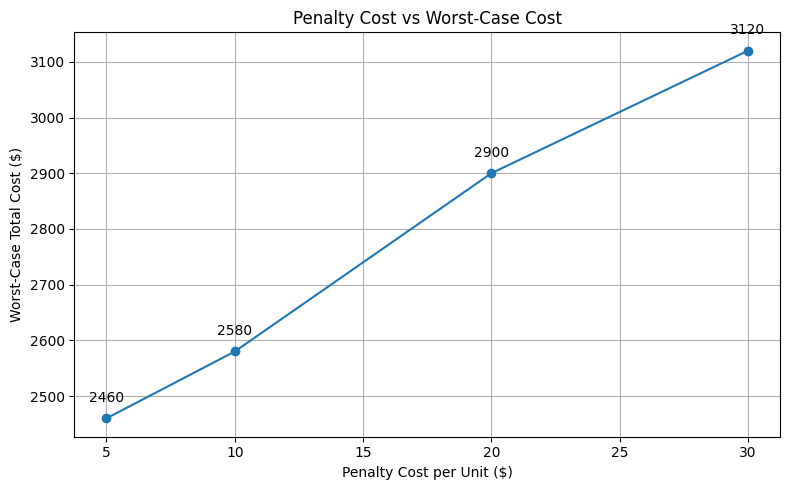

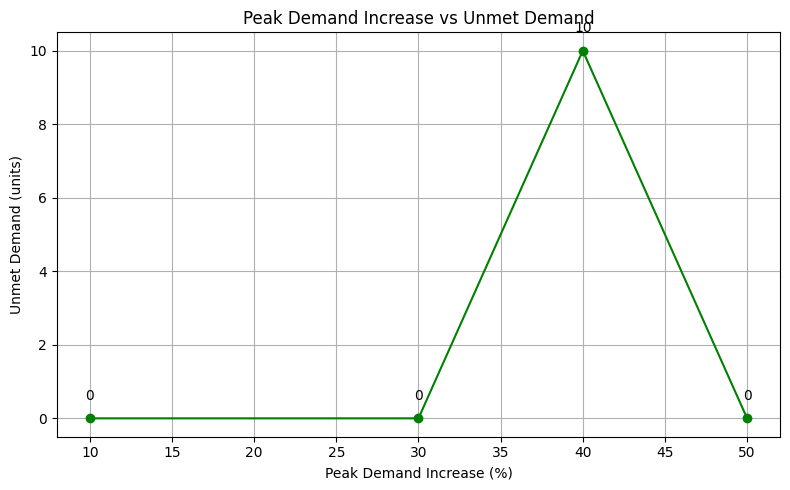

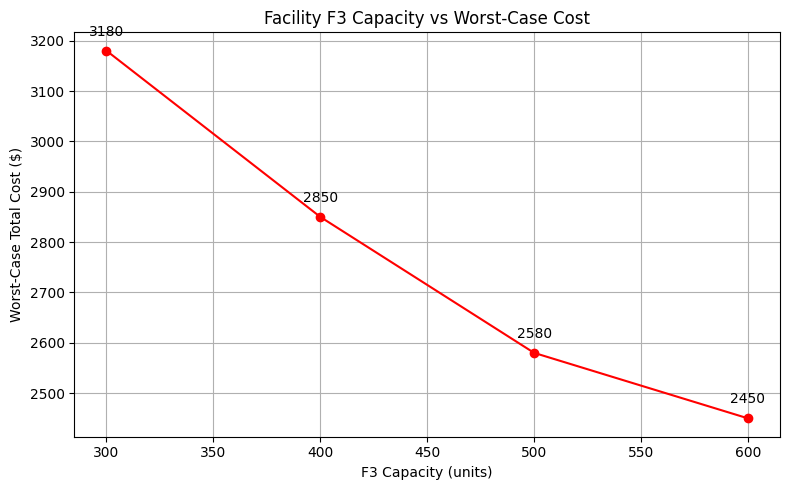

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Scenario 1: Penalty Cost vs Worst-Case Cost
penalty_cost_data = {
    "Penalty Cost": [5, 10, 20, 30],
    "Worst-Case Cost": [2460, 2580, 2900, 3120]
}
df_penalty = pd.DataFrame(penalty_cost_data)

plt.figure(figsize=(8, 5))
plt.plot(df_penalty["Penalty Cost"], df_penalty["Worst-Case Cost"], marker='o')
for i in range(len(df_penalty)):
    plt.text(df_penalty["Penalty Cost"][i], df_penalty["Worst-Case Cost"][i] + 30,
             f'{df_penalty["Worst-Case Cost"][i]}', ha='center')
plt.title("Penalty Cost vs Worst-Case Cost")
plt.xlabel("Penalty Cost per Unit ($)")
plt.ylabel("Worst-Case Total Cost ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scenario 2: Peak Demand Increase vs Unmet Demand
demand_increase_data = {
    "Demand Increase (%)": [10, 30, 40, 50],
    "Unmet Demand (units)": [0, 0, 10, 0]
}
df_demand = pd.DataFrame(demand_increase_data)

plt.figure(figsize=(8, 5))
plt.plot(df_demand["Demand Increase (%)"], df_demand["Unmet Demand (units)"], marker='o', color='green')
for i in range(len(df_demand)):
    plt.text(df_demand["Demand Increase (%)"][i], df_demand["Unmet Demand (units)"][i] + 0.5,
             f'{df_demand["Unmet Demand (units)"][i]}', ha='center')
plt.title("Peak Demand Increase vs Unmet Demand")
plt.xlabel("Peak Demand Increase (%)")
plt.ylabel("Unmet Demand (units)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scenario 3: Facility Capacity vs Worst-Case Cost
capacity_data = {
    "F3 Capacity": [600, 500, 400, 300],
    "Worst-Case Cost": [2450, 2580, 2850, 3180]
}
df_capacity = pd.DataFrame(capacity_data)

plt.figure(figsize=(8, 5))
plt.plot(df_capacity["F3 Capacity"], df_capacity["Worst-Case Cost"], marker='o', color='red')
for i in range(len(df_capacity)):
    plt.text(df_capacity["F3 Capacity"][i], df_capacity["Worst-Case Cost"][i] + 30,
             f'{df_capacity["Worst-Case Cost"][i]}', ha='center')
plt.title("Facility F3 Capacity vs Worst-Case Cost")
plt.xlabel("F3 Capacity (units)")
plt.ylabel("Worst-Case Total Cost ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
